In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
from bayes_opt import BayesianOptimization

In [2]:
flux_columns = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 
       'g_flux_corr', 'nb921_hsc_flux_corr']
error_columns=[
        'E_Total_flux', 'E_Peak_flux',
        'NUV_fluxerr_corr', 'u_fluxerr_corr', 'Bw_fluxerr_corr', 'R_fluxerr_corr',
       'I_fluxerr_corr', 'z_fluxerr_corr', 'y_fluxerr_corr',
       'J_fluxerr_corr', 'H_fluxerr_corr', 'K_fluxerr_corr', 'Ks_fluxerr_corr',
       'ch1_fluxerr_corr', 'ch2_fluxerr_corr', 'ch3_fluxerr_corr', 'ch4_fluxerr_corr',
       'FErr_MIPS_24_u', 'FErr_MIPS_24_l', 'FErr_PACS_100_u', 'FErr_PACS_100_l', 'FErr_PACS_160_u', 'FErr_PACS_160_l'
    , 'FErr_SPIRE_250_u', 'FErr_SPIRE_250_l', 'FErr_SPIRE_350_u', 'FErr_SPIRE_350_l', 'FErr_SPIRE_500_u', 
    'FErr_SPIRE_500_l',
       'g_fluxerr_corr', 'nb921_hsc_fluxerr_corr',
]
combined_columns = np.append(flux_columns, error_columns)

# Importing data

In [3]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")
X = data[combined_columns]

# Manually fixing some fluxes since I didnt convert units on all of them

In [4]:
increase_1e6 = ['E_Total_flux', 'E_Peak_flux']
increase_1e3 = ['FErr_PACS_100_u', 'FErr_PACS_100_l', 'FErr_PACS_160_u', 'FErr_PACS_160_l', 
                'FErr_SPIRE_250_u', 'FErr_SPIRE_250_l', 'FErr_SPIRE_350_u', 'FErr_SPIRE_350_l', 
                'FErr_SPIRE_500_u', 'FErr_SPIRE_500_l']

In [5]:
X[increase_1e6]*=1e6
X[increase_1e3]*=1e3

/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Converting PACS and SPIRE quartiles to stds

In [6]:
non_sigma_columns_u = ['FErr_MIPS_24_u', 'FErr_PACS_100_u', 'FErr_PACS_160_u', 
                     'FErr_SPIRE_250_u', 'FErr_SPIRE_350_u', 'FErr_SPIRE_500_u']
non_sigma_columns_l = ['FErr_MIPS_24_l', 'FErr_PACS_100_l', 'FErr_PACS_160_l', 
                     'FErr_SPIRE_250_l', 'FErr_SPIRE_350_l', 'FErr_SPIRE_500_l']
non_sigma_columns_corresponding = ['F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 
                                 'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500']

In [7]:
# Converting from 84th Percentile to 1 sigma and 16th percentile to 1 sigma and then taking the average
for column1, column2, column3 in zip(non_sigma_columns_u, non_sigma_columns_l, non_sigma_columns_corresponding):
    std1 = np.abs(X[column3] - X[column1])/0.9945
    std2 = np.abs(X[column3] - X[column2])/0.9945
    X[column3 + '_error'] = (std1+std2)/2
    X = X.drop(columns=[column1, column2])

/var/lib/condor/execute/dir_744375/ipykernel_744465/2008349615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column3 + '_error'] = (std1+std2)/2


# Adding S/N columns

In [8]:
signal = ['Total_flux', 'Peak_flux', 'NUV_flux_corr', 'u_flux_corr',
       'Bw_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr',
       'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr',
       'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'g_flux_corr',
       'nb921_hsc_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250',
       'F_SPIRE_350', 'F_SPIRE_500']
noise=[
        'E_Total_flux', 'E_Peak_flux',
       'NUV_fluxerr_corr', 'u_fluxerr_corr', 'Bw_fluxerr_corr',
       'R_fluxerr_corr', 'I_fluxerr_corr', 'z_fluxerr_corr', 'y_fluxerr_corr',
       'J_fluxerr_corr', 'H_fluxerr_corr', 'K_fluxerr_corr', 'Ks_fluxerr_corr',
       'ch1_fluxerr_corr', 'ch2_fluxerr_corr', 'ch3_fluxerr_corr',
       'ch4_fluxerr_corr', 'g_fluxerr_corr', 'nb921_hsc_fluxerr_corr',
       'F_MIPS_24_error', 'F_PACS_100_error', 'F_PACS_160_error',
       'F_SPIRE_250_error', 'F_SPIRE_350_error', 'F_SPIRE_500_error',
]

for flux, error in zip(signal, noise):
    print(flux, error)
    X[flux + '_SN'] = X[flux]/X[error]

Total_flux E_Total_flux
Peak_flux E_Peak_flux
NUV_flux_corr NUV_fluxerr_corr
u_flux_corr u_fluxerr_corr
Bw_flux_corr Bw_fluxerr_corr
R_flux_corr R_fluxerr_corr
I_flux_corr I_fluxerr_corr
z_flux_corr z_fluxerr_corr
y_flux_corr y_fluxerr_corr
J_flux_corr J_fluxerr_corr
H_flux_corr H_fluxerr_corr
K_flux_corr K_fluxerr_corr
Ks_flux_corr Ks_fluxerr_corr
ch1_flux_corr ch1_fluxerr_corr
ch2_flux_corr ch2_fluxerr_corr
ch3_flux_corr ch3_fluxerr_corr
ch4_flux_corr ch4_fluxerr_corr
g_flux_corr g_fluxerr_corr
nb921_hsc_flux_corr nb921_hsc_fluxerr_corr
F_MIPS_24 F_MIPS_24_error
F_PACS_100 F_PACS_100_error
F_PACS_160 F_PACS_160_error
F_SPIRE_250 F_SPIRE_250_error
F_SPIRE_350 F_SPIRE_350_error
F_SPIRE_500 F_SPIRE_500_error


In [9]:
SN_columns = ['Total_flux_SN', 'Peak_flux_SN', 'NUV_flux_corr_SN', 'u_flux_corr_SN',
       'Bw_flux_corr_SN', 'R_flux_corr_SN', 'I_flux_corr_SN', 'z_flux_corr_SN',
       'y_flux_corr_SN', 'J_flux_corr_SN', 'H_flux_corr_SN', 'K_flux_corr_SN',
       'Ks_flux_corr_SN', 'ch1_flux_corr_SN', 'ch2_flux_corr_SN',
       'ch3_flux_corr_SN', 'ch4_flux_corr_SN', 'F_MIPS_24_SN', 'F_PACS_100_SN',
       'F_PACS_160_SN', 'F_SPIRE_250_SN', 'F_SPIRE_350_SN', 'F_SPIRE_500_SN',
       'g_flux_corr_SN']

## Making model

In [10]:
y = data[['Classification', 'Source']]

In [11]:
def AGN(row):
    
    if row['Classification'] == 'jet-mode radio AGN/low-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'quasar-like radio AGN / high-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'radio-quiet AGN':
        return 1
    elif row['Classification'] == 'star-forming galaxy':
        return 0

In [12]:
y['AGN'] =  y.apply(AGN, axis=1, result_type='expand')

/var/lib/condor/execute/dir_744375/ipykernel_744465/3505554675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['AGN'] =  y.apply(AGN, axis=1, result_type='expand')


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y[['AGN', 'Source']], train_size=0.8, stratify=y[['AGN', 'Source']])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test)

In [57]:
X_train = X_train[flux_columns]
X_val = X_val[['Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 
       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [58]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=4,
                     #min_child_weight=6.64,
                     learning_rate=0.30,
                     #reg_alpha=5.89,
                     reg_lambda=10,
                     tree_method='hist',
                     objective='binary:logistic',
                     #eval_metric=['error'],
                     #scale_pos_weight=frac,
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [59]:
eval_set = [(X_train, y_train['AGN']), (X_val, y_val['AGN'])]

In [60]:
model.fit(X_train, y_train['AGN'], verbose=True, eval_set=eval_set, early_stopping_rounds=50)

[10:43:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.57194	validation_1-logloss:0.57498
[1]	validation_0-logloss:0.50248	validation_1-logloss:0.50370
[2]	validation_0-logloss:0.45487	validation_1-logloss:0.45730
[3]	validation_0-logloss:0.42619	validation_1-logloss:0.43029
[4]	validation_0-logloss:0.39771	validation_1-logloss:0.40192
[5]	validation_0-logloss:0.37924	validation_1-logloss:0.38460
[6]	validation_0-logloss:0.36597	validation_1-logloss:0.37203
[7]	validation_0-logloss:0.35573	validation_1-logloss:0.36038
[8]	validation_0-logloss:0.34568	validation_1-logloss:0.35128
[9]	validation_0-logloss:0.33802	validation_1-logloss:0.34447
[10]	validation_0-logloss:0.33143	validation_1-logloss:0.33823
[11]	validation_0-logloss:0.32702	validation_1-logloss:0.33500
[1

[126]	validation_0-logloss:0.20217	validation_1-logloss:0.24634
[127]	validation_0-logloss:0.20169	validation_1-logloss:0.24607
[128]	validation_0-logloss:0.20128	validation_1-logloss:0.24606
[129]	validation_0-logloss:0.20090	validation_1-logloss:0.24564
[130]	validation_0-logloss:0.20059	validation_1-logloss:0.24552
[131]	validation_0-logloss:0.20021	validation_1-logloss:0.24532
[132]	validation_0-logloss:0.20011	validation_1-logloss:0.24527
[133]	validation_0-logloss:0.19989	validation_1-logloss:0.24502
[134]	validation_0-logloss:0.19968	validation_1-logloss:0.24480
[135]	validation_0-logloss:0.19955	validation_1-logloss:0.24462
[136]	validation_0-logloss:0.19913	validation_1-logloss:0.24437
[137]	validation_0-logloss:0.19900	validation_1-logloss:0.24430
[138]	validation_0-logloss:0.19875	validation_1-logloss:0.24410
[139]	validation_0-logloss:0.19866	validation_1-logloss:0.24412
[140]	validation_0-logloss:0.19811	validation_1-logloss:0.24370
[141]	validation_0-logloss:0.19790	valid

[255]	validation_0-logloss:0.16631	validation_1-logloss:0.23199
[256]	validation_0-logloss:0.16614	validation_1-logloss:0.23159
[257]	validation_0-logloss:0.16590	validation_1-logloss:0.23148
[258]	validation_0-logloss:0.16572	validation_1-logloss:0.23150
[259]	validation_0-logloss:0.16561	validation_1-logloss:0.23148
[260]	validation_0-logloss:0.16525	validation_1-logloss:0.23125
[261]	validation_0-logloss:0.16511	validation_1-logloss:0.23133
[262]	validation_0-logloss:0.16505	validation_1-logloss:0.23156
[263]	validation_0-logloss:0.16487	validation_1-logloss:0.23178
[264]	validation_0-logloss:0.16475	validation_1-logloss:0.23175
[265]	validation_0-logloss:0.16455	validation_1-logloss:0.23168
[266]	validation_0-logloss:0.16431	validation_1-logloss:0.23153
[267]	validation_0-logloss:0.16390	validation_1-logloss:0.23176
[268]	validation_0-logloss:0.16363	validation_1-logloss:0.23161
[269]	validation_0-logloss:0.16339	validation_1-logloss:0.23166
[270]	validation_0-logloss:0.16320	valid

[384]	validation_0-logloss:0.14108	validation_1-logloss:0.22841
[385]	validation_0-logloss:0.14099	validation_1-logloss:0.22849
[386]	validation_0-logloss:0.14093	validation_1-logloss:0.22846
[387]	validation_0-logloss:0.14087	validation_1-logloss:0.22831
[388]	validation_0-logloss:0.14078	validation_1-logloss:0.22829
[389]	validation_0-logloss:0.14056	validation_1-logloss:0.22805
[390]	validation_0-logloss:0.14047	validation_1-logloss:0.22806
[391]	validation_0-logloss:0.14039	validation_1-logloss:0.22796
[392]	validation_0-logloss:0.14022	validation_1-logloss:0.22784
[393]	validation_0-logloss:0.14004	validation_1-logloss:0.22810
[394]	validation_0-logloss:0.13979	validation_1-logloss:0.22802
[395]	validation_0-logloss:0.13954	validation_1-logloss:0.22803
[396]	validation_0-logloss:0.13922	validation_1-logloss:0.22797
[397]	validation_0-logloss:0.13897	validation_1-logloss:0.22766
[398]	validation_0-logloss:0.13886	validation_1-logloss:0.22747
[399]	validation_0-logloss:0.13867	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100000, n_jobs=8, nthread=8, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
              subsample=1, tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [61]:
print(classification_report(model.predict(X_test[flux_columns]), y_test['AGN'], digits=4))

              precision    recall  f1-score   support

           0     0.9578    0.9255    0.9414      9379
           1     0.7917    0.8743    0.8309      3038

    accuracy                         0.9129     12417
   macro avg     0.8748    0.8999    0.8861     12417
weighted avg     0.9172    0.9129    0.9144     12417



# Resampling

In [123]:
for i in y_test.Source.unique():
    filt = y['Source']==i
    
    print(i)
    print(X[filt][SN_columns].mean().mean())
    print('------------------------------------------------------------------')

Bootes
47.77302589413223
------------------------------------------------------------------
Lockman
29.212406859829674
------------------------------------------------------------------
Elais-N1
33.214488094815366
------------------------------------------------------------------


In [122]:
filt

15080     True
66705    False
63451    False
3370      True
76127    False
         ...  
20588    False
12560     True
26825    False
40968    False
74545    False
Name: Source, Length: 12417, dtype: bool

In [83]:
X[SN_columns].mean().mean()

39.139456494112686

In [62]:
def resample(X, flux_column, error_column, sn_mult=1):
    noise =  np.random.normal(0, sn_mult*X[error_column])
    
    # adding the noise
    return X[flux_column] + noise

9.93008990396127 4.764354377381294 0        1.131941
1        1.282612
2        1.378502
3        1.468209
4        1.487374
           ...   
65655    9.998552
65656    9.999042
65657    9.999159
65658    9.999298
65659    9.999661
Length: 65660, dtype: float64


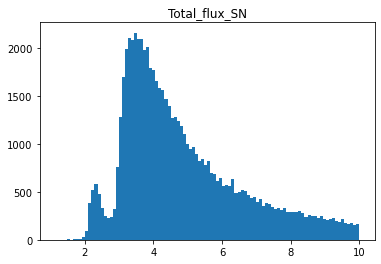

In [63]:

i = 0
print(X[SN_columns[i]].mean(), X[SN_columns[i]].median(), X[SN_columns[i]][X[SN_columns[0]]<10].mode())

plt.hist(X[SN_columns[i]][X[SN_columns[0]]<10], bins=100)
plt.title(SN_columns[i])
#plt.yscale('log')
plt.show()

In [110]:
X_resampled = X_test.copy()
for c1, c2 in zip(signal, noise):
        X_resampled[c1] = resample(X_resampled, c1, c2, 1)

In [111]:
print(classification_report(model.predict(X_resampled[flux_columns]), y_test['AGN'], digits=4))

              precision    recall  f1-score   support

           0     0.9199    0.9254    0.9226      9008
           1     0.7997    0.7870    0.7933      3409

    accuracy                         0.8874     12417
   macro avg     0.8598    0.8562    0.8580     12417
weighted avg     0.8869    0.8874    0.8871     12417



In [114]:
SN_multiple = []
scores = []
for i in range(16):
    for sn in np.linspace(1,20,20):
        # Appending the SN multiple
        SN_multiple.append(sn)
        
        # Making a copy, so we don't edit the original
        X_resampled = X_test.copy()
        # Resampling and calculating macro F1 score
        for c1, c2 in zip(signal, noise):
            X_resampled[c1] = resample(X_resampled, c1, c2, sn)
        score = f1_score(y_test['AGN'], model.predict(X_resampled[flux_columns]), average='macro')
        scores.append(score)

In [115]:
dat_SN = np.array([SN_multiple, scores])
SN_scores = pd.DataFrame(dat_SN.T, columns=['SN multiple', 'Score'])

In [117]:
SN_scores

,SN multiple,Score
0,1.0,0.852499
1,2.0,0.801927
2,3.0,0.740817
3,4.0,0.700960
4,5.0,0.657748
...,...,...
315,16.0,0.487533
316,17.0,0.476976
317,18.0,0.478196
318,19.0,0.470298


In [103]:
SN_scores[SN_scores['SN multiple']==1]

,SN multiple,Score
0,1.0,0.858456
1,1.0,0.796782
2,1.0,0.741333
3,1.0,0.697612
4,1.0,0.663968
5,1.0,0.628823
6,1.0,0.601147
7,1.0,0.579440
8,1.0,0.560433
9,1.0,0.548901


<AxesSubplot:xlabel='SN multiple', ylabel='Score'>

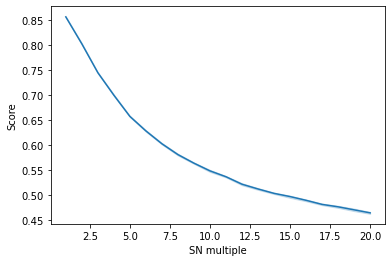

In [118]:
import seaborn as sns

sns.lineplot(data=SN_scores, x='SN multiple', y='Score')

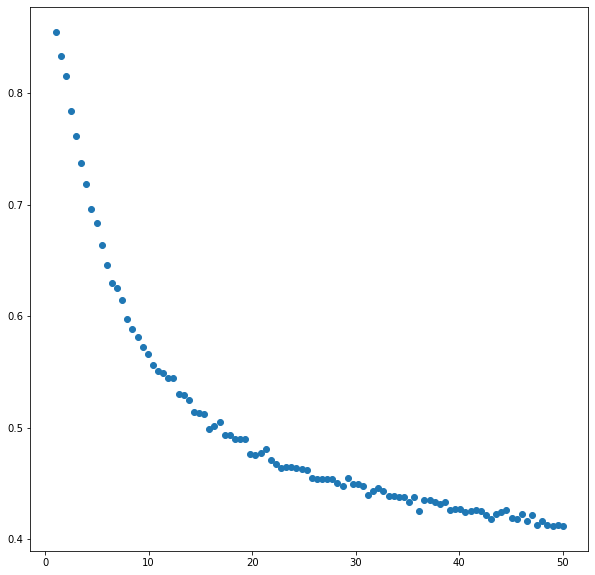

In [446]:
plt.figure(figsize=(10,10))
plt.scatter(np.linspace(1,50,100), scores)

In [391]:
np.max(X['F_PACS_100_SN'])

2843780.383862063

<AxesSubplot:>

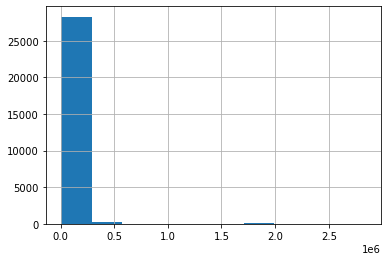

In [358]:
X['F_PACS_100_SN'].hist()

In [355]:
X[~X['F_PACS_100_SN'].isna()]

,Total_flux,Peak_flux,NUV_flux_corr,u_flux_corr,Bw_flux_corr,R_flux_corr,I_flux_corr,z_flux_corr,y_flux_corr,J_flux_corr,...,ch3_flux_corr_SN,ch4_flux_corr_SN,F_MIPS_24_SN,F_PACS_100_SN,F_PACS_160_SN,F_SPIRE_250_SN,F_SPIRE_350_SN,F_SPIRE_500_SN,g_flux_corr_SN,nb921_hsc_flux_corr_SN
17776,327.324616,231.362701,0.103853,2.225503,NaN,9.431653,17.732508,23.053072,28.262405,36.539051,...,4.072887,4.750016,3371.756487,62835.915941,970.368260,1.198195,0.799691,0.798110,0.001031,0.011656
17780,258.333470,233.490262,0.085819,0.038580,NaN,0.112255,0.196781,0.732484,0.883207,0.219245,...,0.939854,2.618097,2625.505928,79178.391496,2412.482078,1.959112,1.473535,10.245682,0.000087,0.000021
17783,154.797922,95.219853,0.346308,4.325897,NaN,7.889939,11.025006,12.383713,12.845549,14.331406,...,0.839274,0.632847,1287.545524,58537.350986,602.894171,0.206756,0.294713,1.418291,0.001999,0.000003
17787,198.643134,232.378631,0.392485,0.306920,NaN,0.552643,0.991651,1.393697,2.990922,3.587674,...,3.408643,4.068122,991.103116,35452.690932,984.972363,0.930171,0.194730,0.243625,0.000105,0.001235
17790,125.978790,101.661490,0.234806,0.020361,NaN,0.189913,0.263285,0.634133,0.357666,0.272440,...,2.241473,0.807916,1140.384584,157423.373790,1942.017129,0.647558,0.649670,2.796439,0.000052,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47679,136.959774,98.140459,0.054149,1.933810,NaN,5.296162,11.382910,16.478394,18.621279,25.480320,...,5.082107,4.538397,4183.966512,54818.143004,1785.524691,0.873515,0.662243,5.006973,0.001107,0.005357
47683,386.584192,244.096566,0.047220,0.023199,NaN,0.265444,0.427951,0.789354,1.157891,2.668579,...,1.642113,1.153079,1088.677320,54374.821145,670.192810,0.241042,0.746421,1.412477,0.000037,0.000102
47686,174.178713,173.716745,0.028489,0.096372,NaN,0.052310,0.140520,NaN,NaN,1.848927,...,2.440421,0.227427,114.187461,39668.126355,1633.542592,0.383326,0.290652,0.874750,NaN,NaN
47692,464.251225,305.212193,0.389015,3.114135,NaN,23.979012,40.055809,57.209148,63.662498,90.897621,...,6.745007,25.264911,5779.606772,32205.204248,2441.248616,1.792676,0.237577,0.549667,0.002783,0.035650
